# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Orient")

In [3]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)
import warnings
warnings.filterwarnings('ignore')
# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

# K-means


Let's start by generating some blobs:


In [66]:
from sklearn.datasets import make_blobs

blob_centers = np.array([
    [0.2, 2.3],
    [-1.5, 2.3],
    [-2.8, 1.8],
    [-2.8, 2.8],
    [-2.8, 1.3],
])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

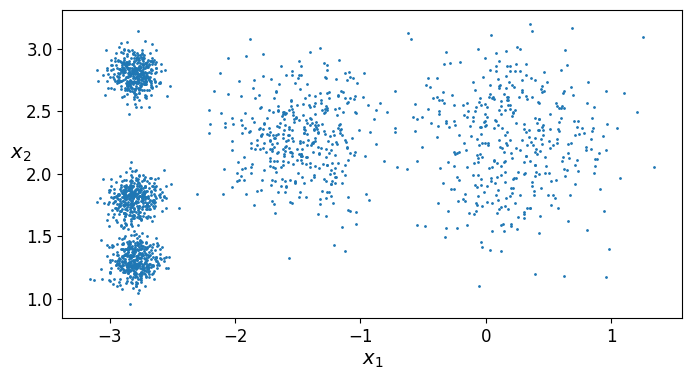

In [67]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


plt.figure(figsize=(8, 4))
plot_clusters(X)
# save_fig("blobs_plot")
plt.show()

**Fit and predict** \
Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:


In [70]:
from sklearn.cluster import KMeans

In [77]:
k = 5
random_state = 0
kmeans = KMeans(
    n_clusters=k, random_state=random_state, init="k-means++"
)  # k-mean++ (default) or random
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:


In [78]:
y_pred

array([4, 1, 2, ..., 3, 2, 1], dtype=int32)

And the following 5 _centroids_ (i.e., cluster centers) were estimated:


In [79]:
kmeans.cluster_centers_

array([[-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Of course, we can predict the labels of new instances:


In [80]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([2, 2, 3, 3], dtype=int32)

**Decision Boundaries**


Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:


In [81]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)


def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=35,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=2,
        linewidths=12,
        color=cross_color,
        zorder=11,
        alpha=1,
    )


def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

**random state 10**


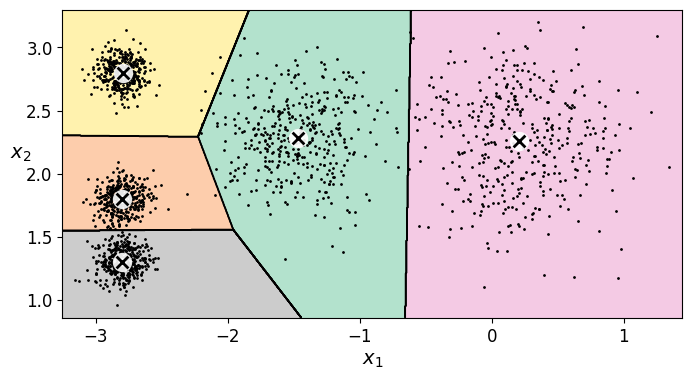

In [82]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
# save_fig("voronoi_plot")
plt.show()

**random state = 42**


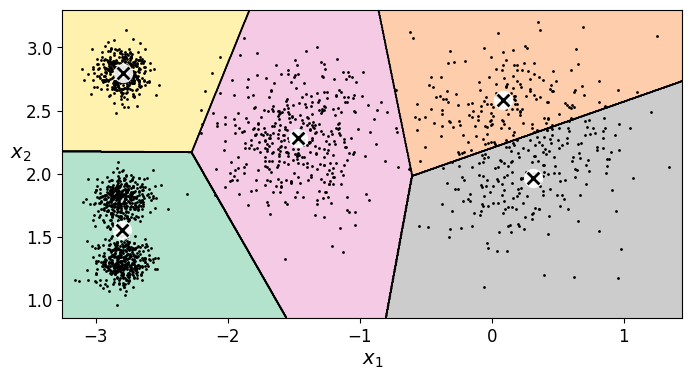

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
# save_fig("voronoi_plot")
plt.show()

### Centroid initialization methods


Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:

- Take one centroid $c_1$, chosen uniformly at random from the dataset.
- Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
- Repeat the previous step until all $k$ centroids have been chosen.


The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.


## K-Means variants


### Accelerated K-Means


To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.


In [83]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

70.4 ms ± 7.26 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [84]:
%timeit -n 50 KMeans(algorithm="lloyd", random_state=42).fit(X)

40.1 ms ± 8.01 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch K-Means


Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches. This speeds up the algorithm typically by a factor of three or four and makes it
possible to cluster huge datasets that do not fit in memory.


In [15]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=10, batch_size=10, random_state=random_state
)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=10)

### Finding the optimal number of clusters


What if the number of clusters was set to a lower or greater value than 5?


In [85]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

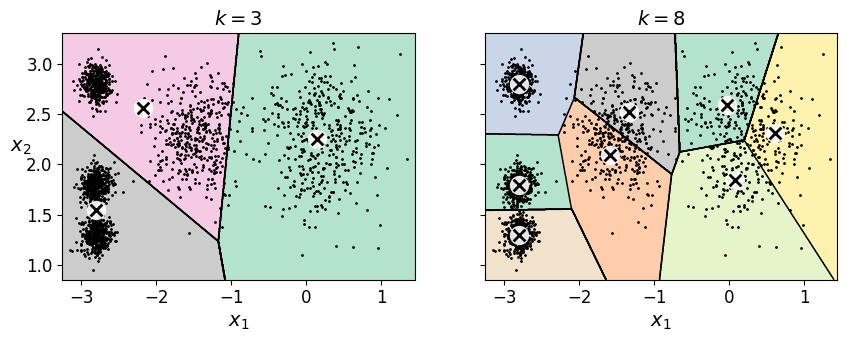

In [86]:
random_state = 10
kmeans_k3 = KMeans(n_clusters=3, random_state=random_state)
kmeans_k8 = KMeans(n_clusters=8, random_state=random_state)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
# save_fig("bad_n_clusters_plot")
plt.show()

### silhouette coefficient to find optimal K clusters


Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.


In [88]:
random_state = 10
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=random_state, init="k-means++").fit(X)
    for k in range(1, 10)
]
inertias = [model.inertia_ for model in kmeans_per_k]

In [89]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [90]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

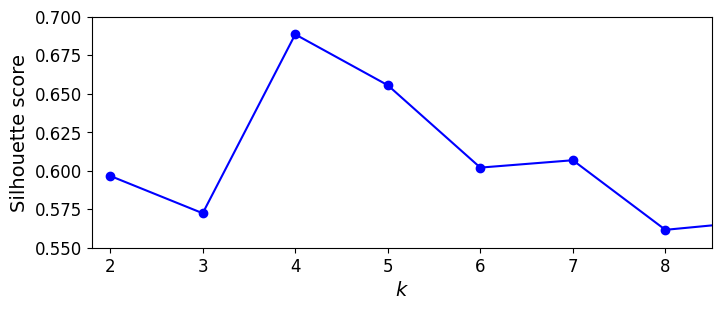

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
# save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.


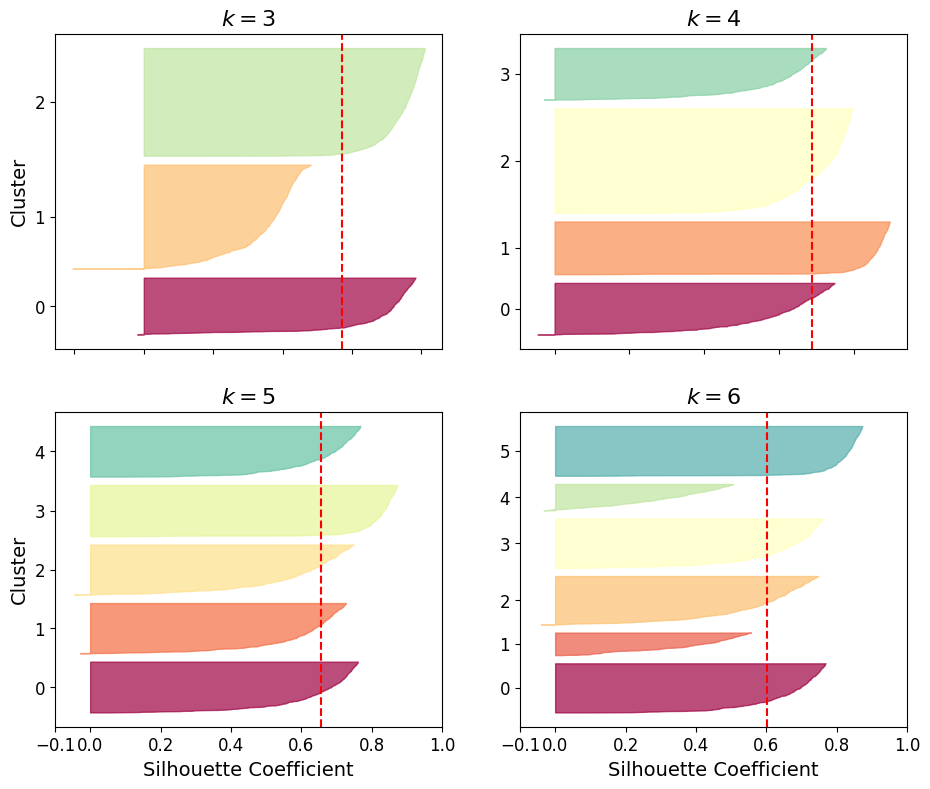

In [92]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(
            np.arange(pos, pos + len(coeffs)),
            0,
            coeffs,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

# save_fig("silhouette_analysis_plot")
plt.show()

## K-Means Applications


**Using Clustering for Image Segmentation**


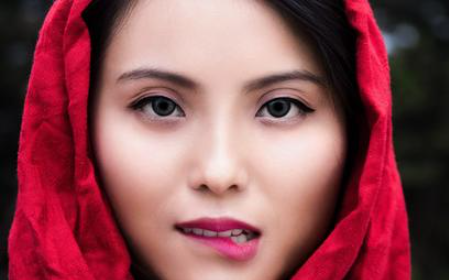

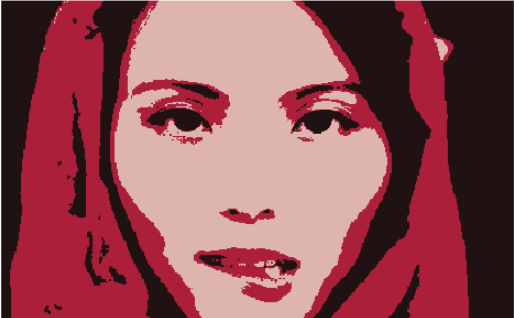


**Using Clustering for Preprocessing**


Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm.


In [93]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)


In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [96]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=0)
log_reg.fit(X_train, y_train)
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.96

We will create a pipeline that will first cluster the training set
into 50 clusters and replace the images with their distances to these 50 clusters, then
apply a Logistic Regression model:


In [97]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=0)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=0)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=0)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=0))])

In [98]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9733333333333334

We can use GridSearchCV to find the optimal number of clusters:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)


Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=0)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=0))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [ ]:
print(grid_clf.best_params_)
print(grid_clf.score(X_test, y_test))

{'kmeans__n_clusters': 96}
0.9822222222222222


# DBSAN

In [99]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [100]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)


DBSCAN(eps=0.05)

 The labels of all the instances are now available in the labels_ instance variable.  Notice that some instances have a cluster index equal to –1, which means that they  are considered as anomalies by the algorithm.

The indices of the core instances are  available in the core_sample_indices_ instance variable, and the core instances themselves are available in the components_ instance variable.

In [101]:
print(dbscan.labels_[:10])
print(len(dbscan.core_sample_indices_))

[ 0  2 -1 -1  1  0  0  0  2  5]
808


In [102]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [103]:
# Core instances positions
dbscan.components_[:10]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 1.26718285, -0.40793471],
       [ 0.87418608,  0.50781041],
       [ 0.3322007 , -0.19032202],
       [ 1.952812  ,  0.22552333]])

In [104]:
# Try with epsilon = 0.2
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [105]:
# Labels
dbscan2.labels_[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [106]:
# Core instances positions
dbscan2.components_[:10]

array([[-0.02137124,  0.40618608],
       [ 0.97670045, -0.45832306],
       [ 0.90405882, -0.37651952],
       [ 0.37736316, -0.39703717],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 0.68246733,  0.80712069]])

In [107]:
np.unique(dbscan2.labels_)

array([0, 1])

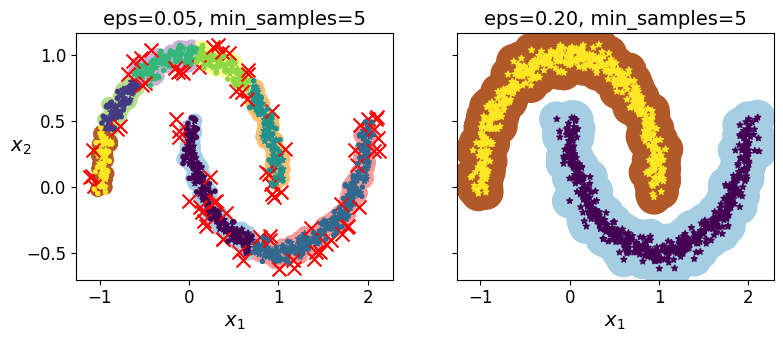

In [109]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

# save_fig("dbscan_plot")
plt.show()


DBSCAN itself cannot predict the new data ==> We use another classifer to predict in this case.

In [110]:
from sklearn.neighbors import KNeighborsClassifier

dbscan = dbscan2
knn = KNeighborsClassifier(n_neighbors=50)
# Only train on core instances
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [111]:
# Predict new data
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print('probabily predict')
print(knn.predict_proba(X_new))
print('label prediction')
print(knn.predict(X_new))

probabily predict
[[0.18 0.82]
 [1.   0.  ]
 [0.12 0.88]
 [1.   0.  ]]
label prediction
[1 0 1 0]


 The decision boundary

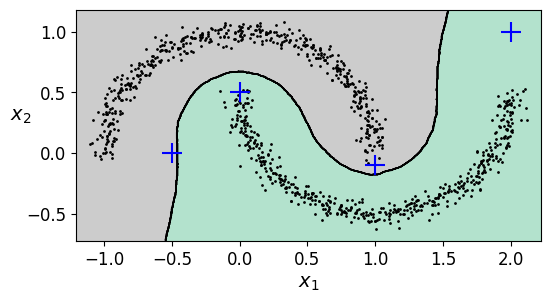

In [112]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
# save_fig("cluster_classification_plot")
plt.show()

 It is fairly straight forward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, use the kneighbors() method of the KNeighborsClassifier.

In [41]:
# The instances with their distances to the closest centroid
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

# Gaussian Mixtures

In [115]:
# create data
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [116]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [117]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [118]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [119]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [120]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [121]:
gm.predict_proba(X)

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [122]:
X_new, y_new = gm.sample(6)
print(X_new)
print(y_new)

[[-2.32491052  1.04752548]
 [-1.16654983  1.62795173]
 [ 1.84860618  2.07374016]
 [ 3.98304484  1.49869936]
 [ 3.8163406   0.53038367]
 [ 0.38079484 -0.56239369]]
[0 0 1 1 1 2]


Now let's plot the resulting decision boundaries (dashed lines) and density contours:

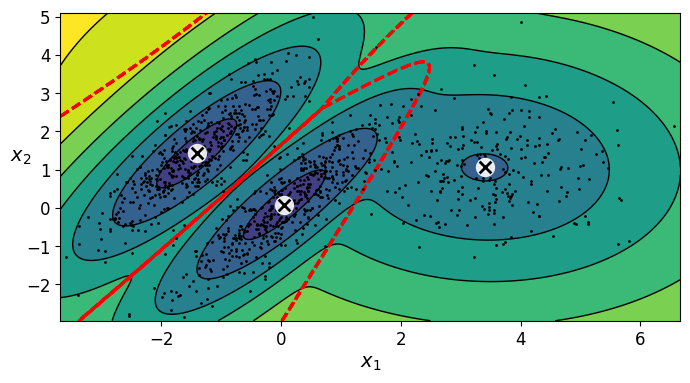

In [123]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

# save_fig("gaussian_mixtures_plot")
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

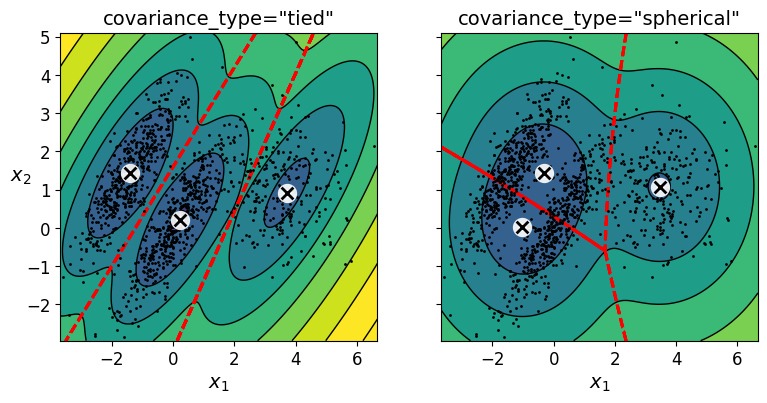

In [51]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

# visualize
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

# save_fig("covariance_type_plot")
plt.show()

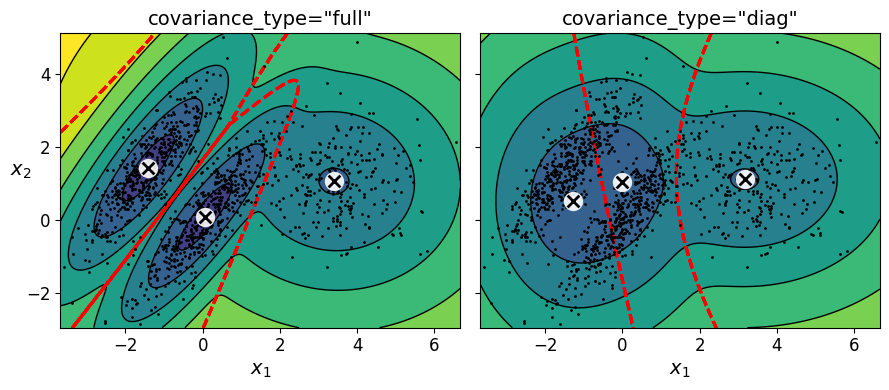

In [52]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection Using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:



In [124]:
X.shape

(1250, 2)

In [125]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [126]:
len(densities)

1250

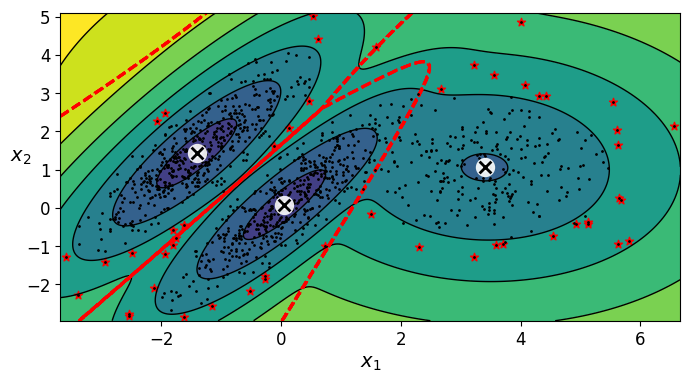

In [127]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

# save_fig("mixture_anomaly_detection_plot")
plt.show()

##**Selecting the Number of Clusters**

you can try to find the model that minimizes a theoretical infor
mation criterion, such as the Bayesian information criterion (BIC) or the Akaike
 information criterion (AIC), defined in


 $$BIC = \log(m)p − 2 \log(L̂) $$\
 $$AIC = 2p − 2\log(L̂)$$

 In these equations: \
 - m is the number of instances, as always.
 - p is the number of parameters learned by the model.
 - L̂ is the maximized value of the likelihood function of the model.


In [128]:
print("BIC:", gm.bic(X))
print("AIC:", gm.aic(X))

BIC: 8189.733705221636
AIC: 8102.508425106598


In [129]:
# Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

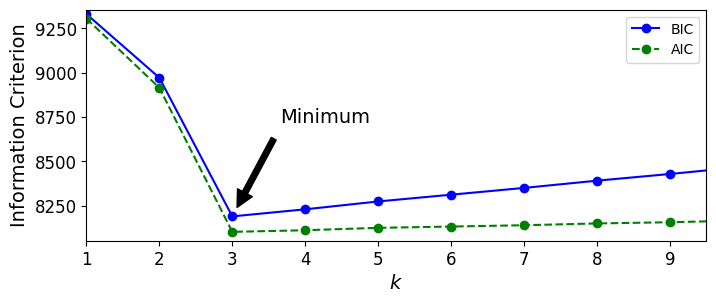

In [130]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
# save_fig("aic_bic_vs_|k_plot")
plt.show()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [131]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [132]:
print('best_k =', best_k)
print('best_covariance_type =', best_covariance_type)

best_k = 3
best_covariance_type = full


## Bayesian Gaussian Mixture Models

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [133]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=10)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=10)

The algorithm automatically detected that only 3 components are needed:

In [134]:
np.round(bgm.weights_, 2)

array([0.4 , 0.2 , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

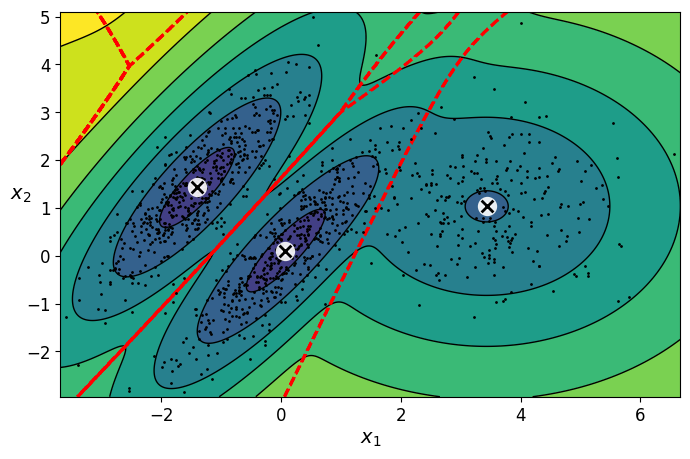

In [135]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

 Gaussian mixture models work great on clusters with ellipsoidal shapes, but if you try
 to fit a dataset with different shapes, you may have bad surprises.

In [136]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

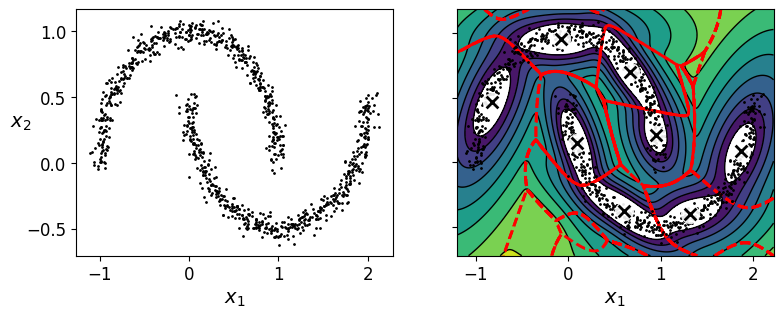

In [137]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

# save_fig("moons_vs_bgm_plot")
plt.show()

Oops! The algorithm desperately searched for ellipsoids, so it found eight different
 clusters instead of two. The density estimation is not too bad, so this model could
 perhaps be used for anomaly detection, but it failed to identify the two moons.